In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt

In [29]:
print("GPUs available:", tf.config.list_physical_devices('GPU'))

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [30]:
# -------------------------
# 1. Load and preprocess data
# -------------------------

data_2017 = "Magaza CSV Files 2017/magaza_1096_2017.csv"
data_2018 = "Magaza CSV Files 2018/magaza_1096_2018.csv"
data_2019 = "Magaza CSV Files 2019/magaza_1096_2019.csv"

df_2017 = pd.read_csv(data_2017)
df_2018 = pd.read_csv(data_2018)
df_2019 = pd.read_csv(data_2019)

data = pd.concat([df_2017, df_2018])
data = data.sort_values('tarih')
data.set_index('tarih', inplace=True)

# We only need the sales column
sales = data[['toplam_satis_adet']]

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sales = scaler.fit_transform(sales)

print(data.head(10))

            magaza_no   mal_no  toplam_satis_tl  toplam_satis_adet
tarih                                                             
2017-01-01       1096  8010701            87.40                 42
2017-01-02       1096  8010701            77.03                 37
2017-01-03       1096  8010701           102.03                 49
2017-01-04       1096  8010701            43.71                 21
2017-01-05       1096  8010701            72.88                 35
2017-01-06       1096  8010701           110.31                 53
2017-01-07       1096  8010701           106.17                 51
2017-01-08       1096  8010701           112.44                 54
2017-01-09       1096  8010701           122.85                 59
2017-01-10       1096  8010701            64.52                 31


In [31]:
# -------------------------
# 2. Create time-series dataset (sliding window)
# -------------------------
def create_dataset(series, window_size=30):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

# Define the window size (e.g., 30 days)
window_size = 30
X, y = create_dataset(scaled_sales, window_size)

In [32]:
# -------------------------
# 3. Train-Test Split
# -------------------------
# For evaluation, we use the last 7 days of the two-year period as test set.
train_size = len(X) - 7
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [34]:
# -------------------------
# 4. Build the LSTM model with Hyperparameter Optimization using Keras Tuner
# -------------------------
def build_model(hp):
    model = Sequential()
    # Tune the number of LSTM units: between 32 and 256
    units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(LSTM(units=units, activation='tanh',
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    # Optionally tune dropout rate
    dropout_rate = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='sales_forecast'
)
with tf.device('/GPU:0'):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop], verbose=1)

    best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 21s]
val_loss: 0.006854244275018573

Best val_loss So Far: 0.006132845068350434
Total elapsed time: 00h 03m 01s


/Users/mertgoker/Documents/Data Science/Senior Design/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [20]:
# -------------------------
# 5. Evaluate the model on test set
# -------------------------
# Predict on test set
y_pred_scaled = best_model.predict(X_test)
# Inverse transform the predictions and true values
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # expressed in percent

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAPE: {mape:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test RMSE: 42.83
Test MAPE: 33.64%


In [21]:
# -------------------------
# 6. Forecast the First Week of the Third Year
# -------------------------
# To forecast beyond the available data, we take the last available window from the two-year dataset.
last_window = scaled_sales[-window_size:]

def forecast_future(model, last_window, forecast_horizon=7):
    forecast = []
    current_window = last_window.copy()
    for i in range(forecast_horizon):
        # model expects input shape (1, window_size, features)
        pred_scaled = model.predict(current_window[np.newaxis, :, :])
        forecast.append(pred_scaled[0, 0])
        # Slide the window: drop the first value and append the prediction
        current_window = np.append(current_window[1:], [[pred_scaled[0, 0]]], axis=0)
    return np.array(forecast)

forecast_scaled = forecast_future(best_model, last_window, forecast_horizon=7)
forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()

# Print the forecasted sales for the next 7 days
print("Forecast for next 7 days (first week of third year):")
for i, val in enumerate(forecast, start=1):
    print(f"Day {i}: {val:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Forecast for next 7 days (first week of third year):
Day 1: 61.56
Day 2: 42.81
Day 3: 43.04
Day 4: 50.98
Day 5: 64.03
Day 6: 71.25
Day 7: 60.06


In [36]:
# -------------------------
# 7. Bootstrap the Forecasts
# -------------------------
# We use the residuals from the test set as an estimate of the forecast error distribution.
y_train_pred_scaled = best_model.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred_scaled)

y_train_true = scaler.inverse_transform(y_train)

residuals = (y_train_true - y_train_pred).flatten()

# Change dtype of forecasts from list to df
forecast = np.reshape(forecast, (1,7))
forecast_df = pd.DataFrame(forecast)

n_bootstrap = 10000
bootstrap_forecasts = np.zeros((n_bootstrap, 7))

for day in range(7):
    forecasted_value = forecast_df[day].iloc[0]
    for i in range(n_bootstrap):
        sampled_residuals = np.random.choice(residuals, size=7, replace=True)
        bootstrap_forecasts[i, :] = forecasted_value + sampled_residuals

bootstrap_forecasts_df = pd.DataFrame(bootstrap_forecasts)
print(bootstrap_forecasts_df.head(10))

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
           0          1          2          3          4          5          6
0  64.936039  55.909872  23.497536  55.138248  70.021122  32.735928  69.324104
1  56.841293  49.226189  71.284607  83.240513  60.795383  58.103260  38.081478
2  59.818371  62.047840  78.397732  66.572422  70.094879  51.669167  59.118774
3  54.430351  55.909872  56.229565  62.469000  56.063042  65.601768  52.199039
4  78.736305  56.921816  49.816956  67.310062  70.579590  48.838528  54.507015
5  57.602135  54.881817  63.480389  67.616886  41.109798  49.103329  58.591019
6  53.909557  85.935081  54.603897  60.386707  49.949596  56.749847  55.202160
7  55.277527  58.569164  57.817009  39.310619  66.491539  58.938711  71.126152
8  50.728279  49.103329  73.162945  78.736305  69.324104  59.873299  43.156204
9  57.797024  55.460960  52.608273  61.877594  75.823154  58.938711  55.448612


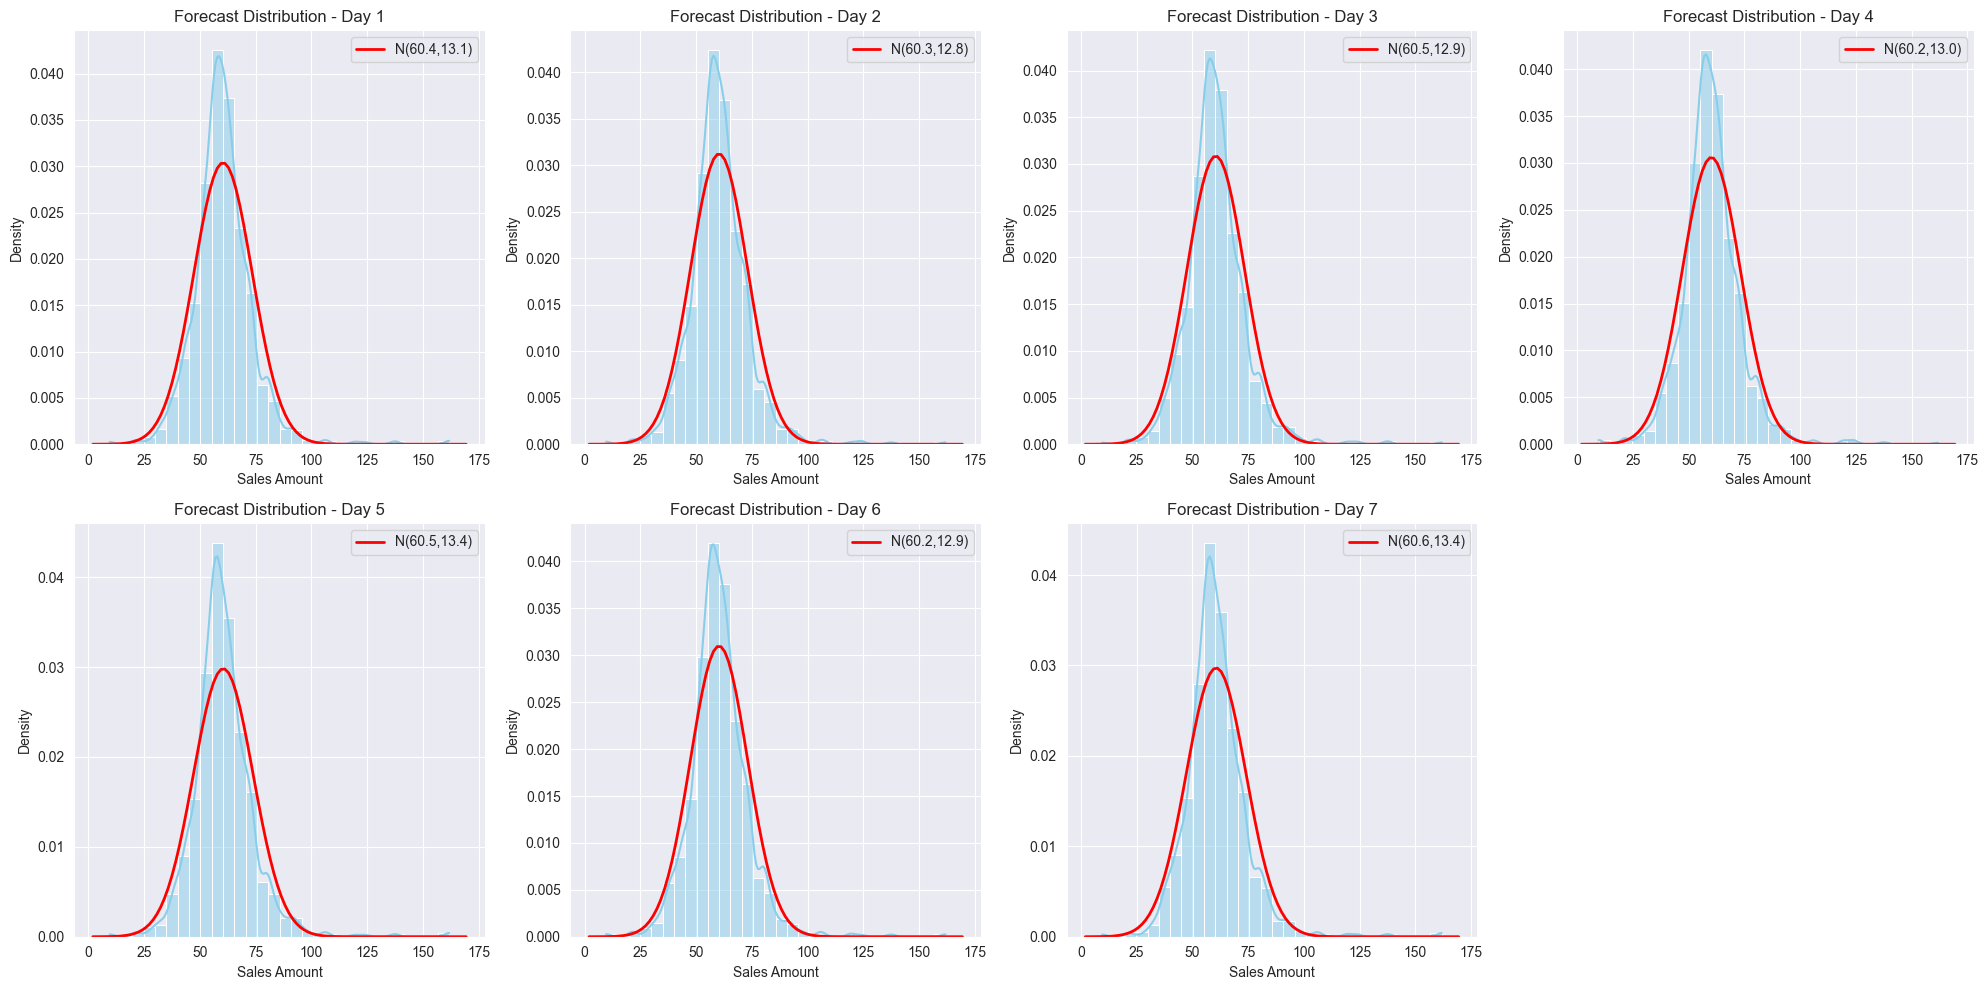

In [23]:
 # -------------------------
# 8. Visualize the Bootstrapped Forecast Distributions
# -------------------------
# Create subplots for each day’s forecast distribution.
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i in range(7):
    samples = bootstrap_forecasts_df[i]
    ax = axes[i]
    sns.histplot(samples, kde=True, ax=ax, stat="density", bins=30, color='skyblue')
    ax.set_title(f"Forecast Distribution - Day {i+1}")
    ax.set_xlabel("Sales Amount")
    ax.set_ylabel("Density")
    # Optionally, overlay a fitted normal distribution curve
    mu, std = stats.norm.fit(samples)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p, 'r', linewidth=2, label=f"N({mu:.1f},{std:.1f})")
    ax.legend()

# Remove any unused subplot if exists
if len(axes) > 7:
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [37]:
def plot_histogram(data, index):
    bin_count = int(np.sqrt(len(data)))
    plt.subplot(1,2,1)
    sns.histplot(data=data, bins=bin_count, kde=False, color='blue')
    index += 1
    plt.title(f"Sales Histogram of Day-{index}")
    plt.xlabel("Sales Quantity")
    plt.ylabel("Frequency")

def plot_distribution(data, index):
    plt.subplot(1,2,2)
    sns.kdeplot(data=data, fill=True, color='red')
    index += 1
    plt.title(f"Sales Distribution of Day-{index}")
    plt.xlabel("Sales Quantity")

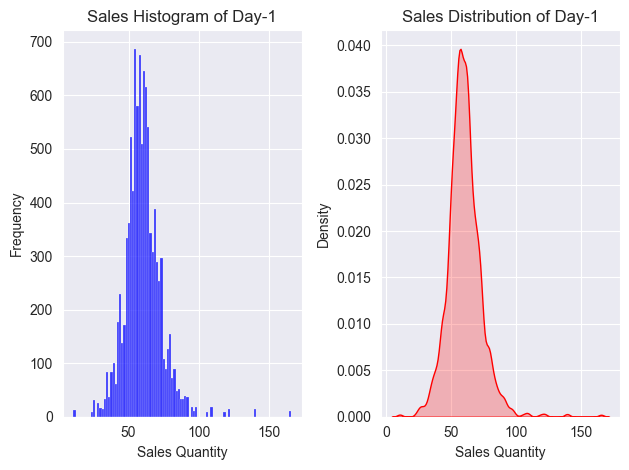

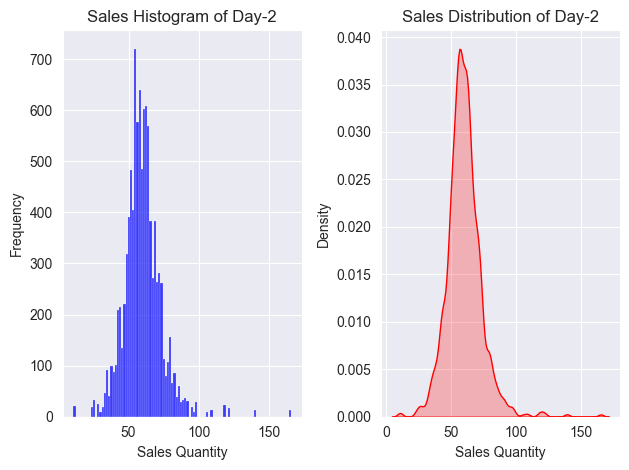

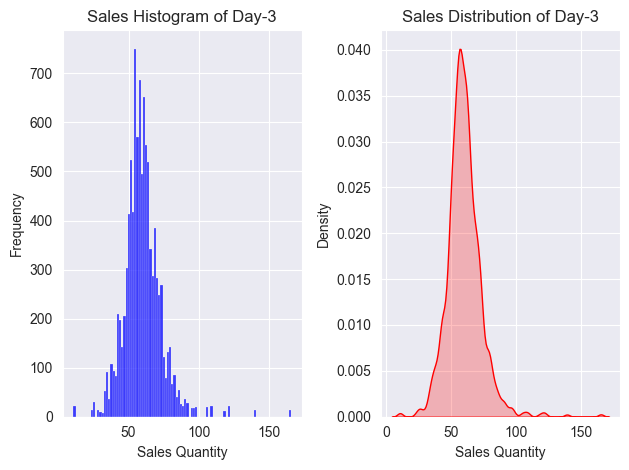

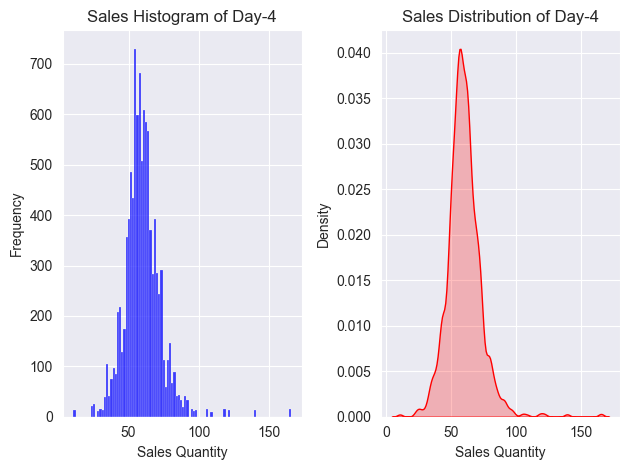

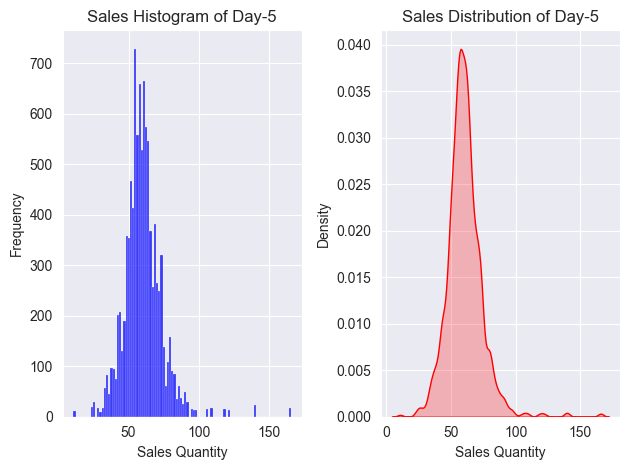

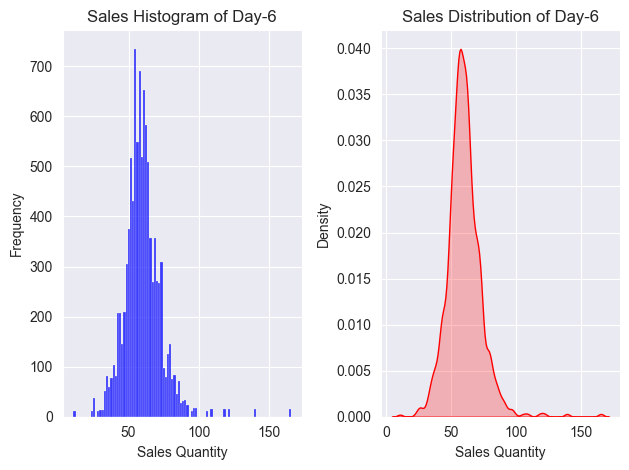

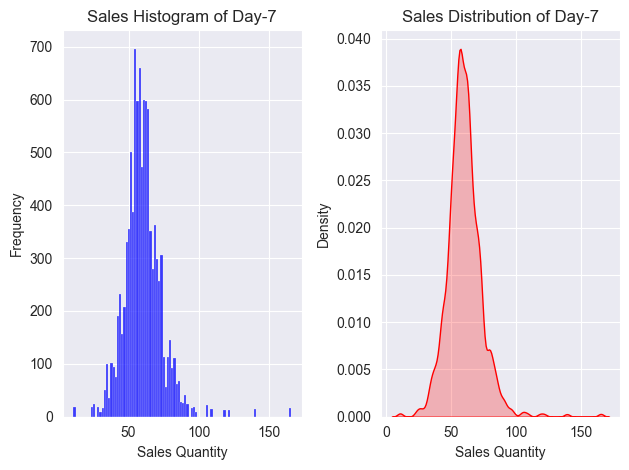

In [38]:
# Plot Histogram & Distribution
i = 0
for col in bootstrap_forecasts_df.columns:
    plot_histogram(bootstrap_forecasts_df[col], i)
    plot_distribution(bootstrap_forecasts_df[col], i)

    plt.tight_layout()
    plt.show()
    i += 1

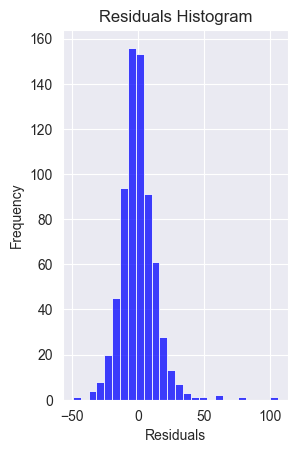

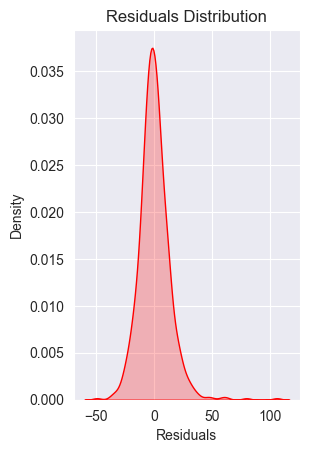

In [39]:
# -------------------------
# 9. Visualize the Residuals
# -------------------------
# Create a histogram plot and a distribution plot for residuals

data = residuals
bin_count = int(np.sqrt(len(data)))
plt.subplot(1,2,1)
sns.histplot(data=data, bins=bin_count, kde=False, color='blue')
plt.title(f"Residuals Histogram")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

plt.show()

plt.subplot(1,2,2)
sns.kdeplot(data=data, fill=True, color='red')
plt.title(f"Residuals Distribution")
plt.xlabel("Residuals")

plt.show()